## 0. 문제
- Task : 생존 시간 예측 (regression 문제)

## 1. 사용 library import

In [169]:
import os
from time import sleep, time
from collections import deque
from itertools import combinations
from pprint import pprint
import math

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import squarify

from pandas_profiling import ProfileReport

plt.style.use('seaborn-whitegrid')
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

## 2. 생성된 Data Frame 불러오기

In [76]:
df = pd.read_csv('./data/2020_torunaments.csv')
df.head()

,dbnos,assists,boosts,damage_dealt,death_type,headshot_kills,heals,kill_place,kill_streaks,kills,...,walk_distance,weapons_acquired,win_place,match_mapName,match_duration,match_createdAt,roster_rank,roster_won,tournament_id,tournament_createdAt
0,1,0,2,178.78679,byplayer,0,7,20,1,1,...,706.84840,7,4,Miramar,1742,2020-12-19T07:39:25Z,4,False,as-pwi20,2020-12-19T07:04:54Z
1,0,0,1,0.00000,byplayer,0,1,33,0,0,...,630.31635,4,4,Miramar,1742,2020-12-19T07:39:25Z,4,False,as-pwi20,2020-12-19T07:04:54Z
2,1,0,1,100.00000,byplayer,0,3,34,0,0,...,1328.34330,3,4,Miramar,1742,2020-12-19T07:39:25Z,4,False,as-pwi20,2020-12-19T07:04:54Z
3,1,0,0,207.98430,byplayer,0,1,21,1,1,...,1109.39770,4,4,Miramar,1742,2020-12-19T07:39:25Z,4,False,as-pwi20,2020-12-19T07:04:54Z
4,1,0,3,189.19508,byplayer,1,6,25,1,1,...,1024.16360,3,8,Miramar,1742,2020-12-19T07:39:25Z,8,False,as-pwi20,2020-12-19T07:04:54Z


In [92]:
df.columns

Index(['dbnos', 'assists', 'boosts', 'damage_dealt', 'death_type',
       'headshot_kills', 'heals', 'kill_place', 'kill_streaks', 'kills',
       'longest_kill', 'name', 'player_id', 'revives', 'ride_distance',
       'road_kills', 'swim_distance', 'team_kills', 'time_survived',
       'vehicle_destroys', 'walk_distance', 'weapons_acquired', 'win_place',
       'match_mapName', 'match_duration', 'match_createdAt', 'roster_rank',
       'roster_won', 'tournament_id', 'tournament_createdAt'],
      dtype='object')

## 3. train / test 분리
* train : 40개 tournaments
* test : 최근 14개 tournaments

In [77]:
# test_tournaments
tournaments = df.groupby(['tournament_id', 'tournament_createdAt'])
tournaments = sorted([(d, i, tmp.shape[0]) for (i,d), tmp in tournaments], key=lambda x: x[0])
test_tournaments = [b for a,b,c in tournaments[-14:]]
print(test_tournaments)

['sea-ptmsr', 'as-osm20', 'as-pcs3as', 'eu-pcs3gf', 'sea-vpt20', 'as-icc20', 'as-jk2020', 'as-bsc3', 'eu-dhsw20', 'as-apl', 'na-dhsw20', 'cn-dgls11', 'cn-htgis8', 'as-pwi20']


In [78]:
# train_tournaments
train_tournaments = [t for t in df.tournament_id.unique() if t not in test_tournaments]
print(train_tournaments)

['eu-pcs3gs', 'sea-ptms20', 'sea-pps2', 'cn-pcsa', 'oc-ods20', 'sea-psms2', 'eu-dachs20', 'sa-cpms3', 'oc-lp3pl', 'as-pcs3kr', 'eu-psl7', 'sea-pcs2ap', 'na-pcs2gf', 'as-pcs2as', 'kr-lvup', 'sea-pis2', 'na-chall2', 'eu-pcs2gs', 'sea-pps1', 'na-pcs2gs', 'as-pcs2kr', 'sa-pmcs2', 'sea-ptsp3', 'sea-pcs1ap', 'na-chall', 'eu-pcs1gs', 'na-pcs1gf', 'sea-pis20', 'sa-cpm20', 'eu-pcscsgf', 'as-pcs1kr', 'eu-dhs20gf', 'sea-lpt20', 'as-pcls20', 'as-pclps19', 'eu-testq', 'sea-pss20', 'sea-pvs20', 'tst-hsm', 'kr-bsc20', 'kr-nr20']


In [82]:
train_df = df[df.tournament_id.isin(train_tournaments)] 
train_df = train_df.query('tournament_id!="eu-testq"') 
test_df = df[df.tournament_id.isin(test_tournaments)]

In [117]:
x_test, y_test = test_df.drop('time_survived', axis=1), test_df.time_survived

In [91]:
a1, a2 = train_df.shape[0]/(train_df.shape[0]+test_df.shape[0]), test_df.shape[0]/(train_df.shape[0]+test_df.shape[0])
print(f'train:test 비율 : {round(a1*100, 2)}:{round(a2*100, 2)}')

train:test 비율 : 82.39:17.61


## 3. 전처리
- 컬럼 삭제
    * win_place
    * tournament_createdAt
    * tournament_id
    * player_id
    * match_createdAt
    * name

In [96]:
train_df.drop(columns=['win_place', 'tournament_createdAt', 'tournament_id', 'player_id', 'match_createdAt', 'name'], inplace=True)
test_df.drop(columns=['win_place', 'tournament_createdAt', 'tournament_id', 'player_id', 'match_createdAt', 'name'], inplace=True)

In [110]:
train_df.columns

Index(['dbnos', 'assists', 'boosts', 'damage_dealt', 'death_type',
       'headshot_kills', 'heals', 'kill_place', 'kill_streaks', 'kills',
       'longest_kill', 'revives', 'ride_distance', 'road_kills',
       'swim_distance', 'team_kills', 'time_survived', 'vehicle_destroys',
       'walk_distance', 'weapons_acquired', 'match_mapName', 'match_duration',
       'roster_rank', 'roster_won'],
      dtype='object')

## 4. pycaret

### 4.1. setup

In [104]:
from pycaret.regression import *
setup(data=train_df, train_size=0.8, silent=True, fold=5, target='time_survived')
print('setup 완료')

,Description,Value
0,session_id,1120
1,Target,time_survived
2,Original Data,"(110409, 24)"
3,Missing Values,False
4,Numeric Features,9
5,Categorical Features,14
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(88327, 126)"


setup 완료


### 4.2 metric 확인

In [105]:
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Custom
ID,,,,,,,,
mae,MAE,MAE,<function mean_absolute_error at 0x0000015402E...,neg_mean_absolute_error,pred,{},False,False
mse,MSE,MSE,<function mean_squared_error at 0x0000015402E7...,neg_mean_squared_error,pred,{},False,False
rmse,RMSE,RMSE,<function mean_squared_error at 0x0000015402E7...,neg_root_mean_squared_error,pred,{'squared': False},False,False
r2,R2,R2,<function r2_score at 0x0000015402E729D0>,r2,pred,{},True,False
rmsle,RMSLE,RMSLE,<function RMSLEMetricContainer.__init__.<local...,"make_scorer(root_mean_squared_log_error, great...",pred,{},False,False
mape,MAPE,MAPE,<function MAPEMetricContainer.__init__.<locals...,"make_scorer(mean_absolute_percentage_error, gr...",pred,{},False,False


### 4.3 사용가능 모델

In [107]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


### 4.4 모델 비교

In [109]:
best5 = compare_models(fold=5,   
                       sort='rmse',
                       n_select=5,    
                       exclude=['svm']) 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,101.8246,19096.5841,138.1825,0.8754,0.1514,0.1110,10.1200
lightgbm,Light Gradient Boosting Machine,103.7847,19879.0327,140.9838,0.8703,0.1540,0.1161,0.9440
xgboost,Extreme Gradient Boosting,104.7487,20254.5051,142.3113,0.8678,0.1516,0.1083,12.9960
et,Extra Trees Regressor,105.6603,21101.0086,145.2511,0.8623,0.1512,0.1084,45.8700
rf,Random Forest Regressor,106.3578,21488.4459,146.5796,0.8598,0.1515,0.1086,42.8160
gbr,Gradient Boosting Regressor,117.2635,23954.5918,154.7686,0.8437,0.1723,0.1340,12.3220
br,Bayesian Ridge,145.4391,35278.5626,187.8233,0.7698,0.2448,0.1898,1.6360
ridge,Ridge Regression,145.4511,35281.8602,187.8321,0.7698,0.2447,0.1898,0.0900
lr,Linear Regression,145.4912,35341.4555,187.9905,0.7694,0.2451,0.1901,1.1220
lasso,Lasso Regression,148.8926,36534.4289,191.1373,0.7616,0.2458,0.1895,1.5660


In [111]:
best5

 LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1120, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='reg:squarederror', random_state=1120, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=

### 4.5 lgbm

In [112]:
lgbm = best5[1]

In [123]:
tuned_lgbm = tune_model(lgbm, fold=5, optimize='r2', search_library='optuna')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,105.0230,20225.8074,142.2175,0.8696,0.1590,0.1255
1,102.5604,19303.9041,138.9385,0.8734,0.1577,0.1282
2,104.5910,20248.7746,142.2982,0.8689,0.1569,0.1108
3,104.7340,20009.9050,141.4564,0.8674,0.1547,0.1190
4,105.4047,20584.3338,143.4724,0.8659,0.1552,0.1217
Mean,104.4626,20074.5450,141.6766,0.8690,0.1567,0.1210
SD,0.9910,426.8926,1.5132,0.0025,0.0016,0.0060


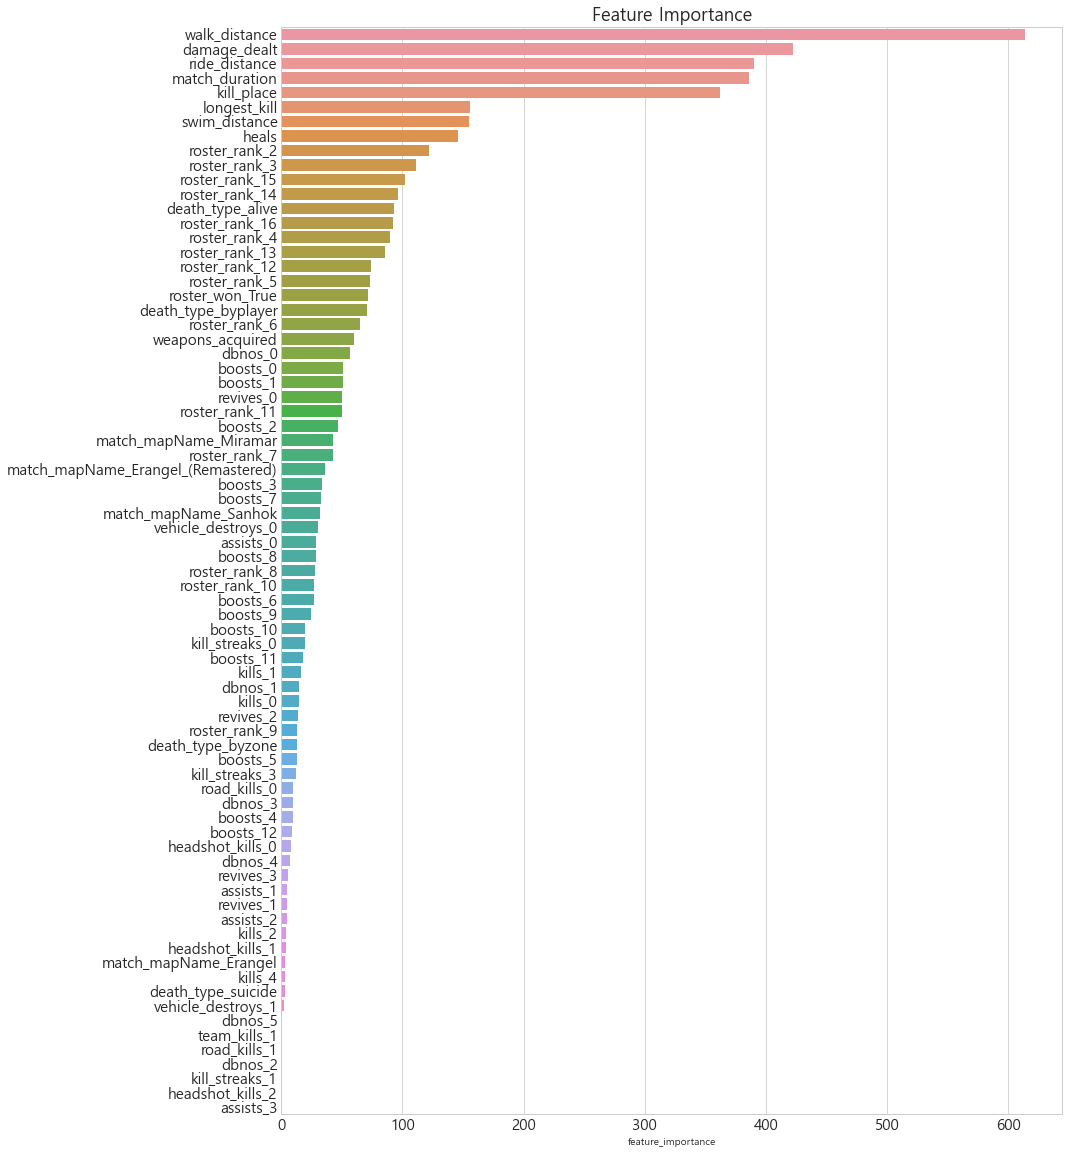

In [174]:
feature_importances = pd.DataFrame(tuned_lgbm.feature_importances_, columns=['feature_importance'], index=tuned_lgbm.feature_name_)
feature_importances = feature_importances.query('feature_importance>0').sort_values(by='feature_importance', ascending=False)

plt.figure(figsize=(14, 20))
sns.barplot(data=feature_importances, x='feature_importance', y=feature_importances.index)
plt.title('Feature Importance', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [162]:
pred = predict_model(tuned_lgbm, data=x_test)

In [170]:
r2 = r2_score(y_test, pred['Label'])
print('r2 score : ', r2)

mae = mean_absolute_error(y_test, pred['Label'])
print('mae : ', mae)

r2 score :  0.8507398066160787
mae :  113.05907235392137


(array([ 632.,  971., 1222., 1958., 2558., 3877., 4326., 3361., 2812.,
        1883.]),
 array([3.4300000e-01, 1.9241430e+02, 3.8448560e+02, 5.7655690e+02,
        7.6862820e+02, 9.6069950e+02, 1.1527708e+03, 1.3448421e+03,
        1.5369134e+03, 1.7289847e+03, 1.9210560e+03]),
 <BarContainer object of 10 artists>)

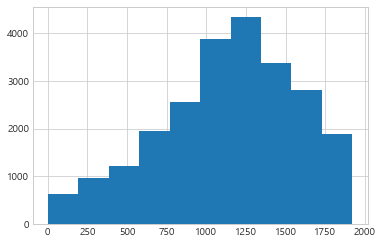

In [175]:
plt.hist(y_test)

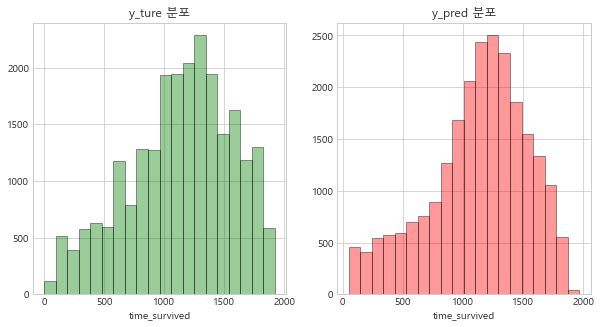

In [184]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.distplot(y_test, bins=20, kde=False, ax=ax[0], color='g', hist_kws={'edgecolor':'k'})
ax[0].set_title('y_ture 분포')


sns.distplot(pred['Label'], bins=20, kde=False, ax=ax[1], color='r', hist_kws={'edgecolor':'k'})
ax[1].set_title('y_pred 분포')
ax[1].set_xlabel('time_survived')
plt.show()